# 1. Descargar los datos de label studio
* Recodar exportar las etiquetas en formato YOLO y guardarlas en su carpeta respectivas

In [ ]:
import os
import requests
from dotenv import load_dotenv
from label_studio_sdk import Client

load_dotenv()  # Carga variables desde .env

LABEL_STUDIO_URL = os.getenv("LABEL_STUDIO_URL")
API_KEY = os.getenv("LABEL_STUDIO_API_KEY")

In [ ]:
# Inicializar el cliente
ls = Client(url=LABEL_STUDIO_URL, api_key=API_KEY)

# Obtener todos los proyectos
projects = ls.get_projects()

# Imprimir detalles de cada proyecto
print(f"Proyectos encontrados: {len(projects)}")
for project in projects:
    print(f"ID: {project.id} - Nombre: {project.get_params()['title']}")

In [ ]:
def download_images_from_label_studio(project_id: int, output_dir: str):
    # Crear carpeta de salida si no existe
    os.makedirs(output_dir, exist_ok=True)

    # Conectar con Label Studio
    ls = Client(url=LABEL_STUDIO_URL, api_key=API_KEY)
    project = ls.get_project(project_id)
    tasks = project.get_tasks()
    total = len(tasks)
    print(f"Total imágenes encontradas: {total}")
    print(f"Descargando {total} imágenes...")

    for i, task in enumerate(tasks, start=1):
        image_path = task['data'].get('image')
        if image_path:
            full_url = f"{LABEL_STUDIO_URL}{image_path}"
            file_name = os.path.basename(image_path)
            output_path = os.path.join(output_dir, file_name)

            response = requests.get(full_url, headers={'Authorization': f'Token {API_KEY}'}, stream=True)
            if response.status_code == 200:
                with open(output_path, 'wb') as f:
                    for chunk in response.iter_content(chunk_size=8192):
                        f.write(chunk)
                print(f"[{i}/{total}] ✅ Descargado: {file_name}")
            else:
                print(f"[{i}/{total}] ❌ Error al descargar {file_name}: {response.status_code}")
        else:
            print(f"[{i}/{total}] ⚠️ Tarea sin imagen asociada")

In [ ]:
# Votación
download_images_from_label_studio(project_id=12, output_dir='../../data/dataset_etiquetado_columnas/c_etiquetados/images')

# B. Probar máscaras


In [15]:
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualizar_yolo_labels(nombre_base: str,
                           images_dir='../../data/dataset_etiquetado_columnas/c_etiquetados/images',
                           labels_dir='../../data/dataset_etiquetado_columnas/c_etiquetados/labels',
                           classes_file='../../data/dataset_etiquetado_columnas/c_etiquetados/classes.txt',
                           ext='.jpg'):
    """
    Visualiza una imagen junto con sus anotaciones YOLO.

    Args:
        nombre_base (str): Nombre del archivo sin extensión (por ejemplo: '0ace00af-172_votacion').
        images_dir (str): Ruta al directorio de imágenes.
        labels_dir (str): Ruta al directorio de etiquetas.
        classes_file (str): Ruta al archivo con nombres de clases.
        ext (str): Extensión de la imagen (por defecto '.jpg').
    """
    # Construir rutas
    image_path = os.path.join(images_dir, nombre_base + ext)
    label_path = os.path.join(labels_dir, nombre_base + '.txt')

    # Leer clases
    with open(classes_file, 'r', encoding='utf-8') as f:
        classes = [line.strip() for line in f.readlines()]

    # Leer imagen
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"No se pudo cargar la imagen: {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape

    # Crear figura
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image)

    # Leer etiquetas
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue  # línea inválida
                class_id = int(parts[0])
                cx, cy, bw, bh = map(float, parts[1:])

                # Convertir a coordenadas absolutas
                x = (cx - bw / 2) * w
                y = (cy - bh / 2) * h
                bw = bw * w
                bh = bh * h

                # Dibujar rectángulo
                rect = patches.Rectangle((x, y), bw, bh, linewidth=2,
                                         edgecolor='lime', facecolor='none')
                ax.add_patch(rect)

                # Añadir nombre de clase
                label = classes[class_id] if class_id < len(classes) else f"Clase {class_id}"
                ax.text(x, y - 5, label, color='lime', fontsize=12,
                        bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))
    else:
        print(f"⚠️ No se encontró la etiqueta: {label_path}")

    ax.axis('off')
    ax.set_title(f"Visualización: {nombre_base + ext}")
    plt.show()

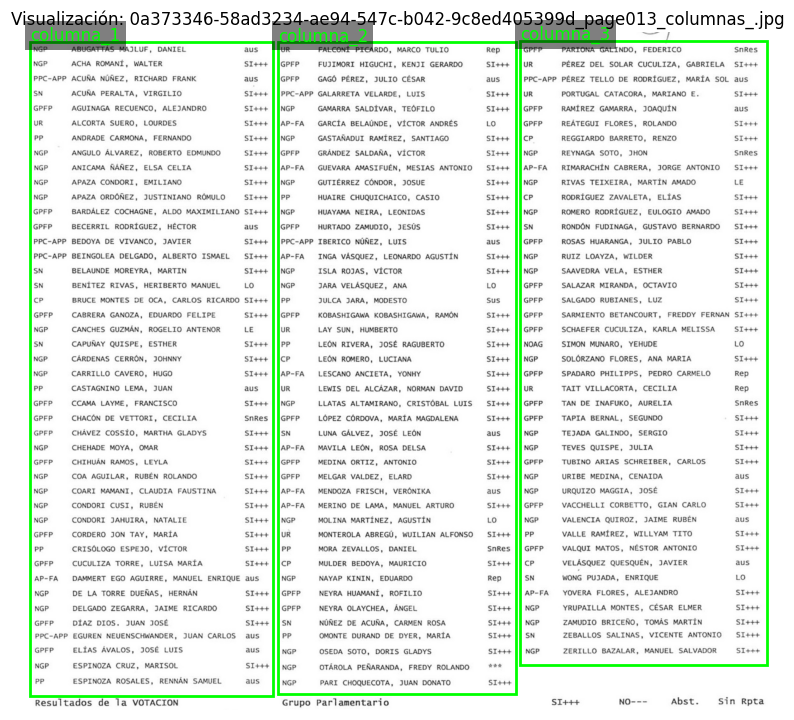

In [16]:
visualizar_yolo_labels('0a373346-58ad3234-ae94-547c-b042-9c8ed405399d_page013_columnas_')
